# Milestone 2 — EDA Dashboard
**QM 2023 Capstone Project · 1st Row Team**  
Nevaeh Marquez · Logan Ledbetter · Raleigh Elizabeth Wullkotte · Sam Bronner

---

**Research Question:** How does hurricane activity and landfall exposure in Florida relate to housing-market outcomes (home values, rents, inventory, market temperature) across Florida MSAs?

**Prerequisite:** Run the Milestone 1 data pipeline first:  
```bash
python code/capstone_data_pipeline.py
```
This notebook reads `data/final/housing_analysis_panel.csv` produced by that pipeline.

### Notebook Contents
1. Setup & Configuration
2. Data Loading & Overview
3. Summary Statistics (by Metro & Time Period)
4. Correlation Heatmap — Hurricane Exposure vs. Housing Outcomes
5. Lagged Effect Analysis — Event Study & Cross-Correlation
6. Metro Segmentation — Sensitive vs. Resilient MSAs
7. Time-Series Decomposition — Trend, Seasonality, Residuals
8. Hurricane Impact Timeline
9. Key Takeaways

---
## 1. Setup & Configuration

In [1]:
# ---------------------------------------------------------------------------
# Imports
# ---------------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# ---------------------------------------------------------------------------
# Paths (mirrors capstone_data_pipeline.py conventions)
# ---------------------------------------------------------------------------
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "code" else Path.cwd()
DATA_FINAL   = PROJECT_ROOT / "data" / "final" / "housing_analysis_panel.csv"
FIGURES_DIR  = PROJECT_ROOT / "results" / "figures"
TABLES_DIR   = PROJECT_ROOT / "results" / "tables"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)

# ---------------------------------------------------------------------------
# Plot defaults — publication-ready
# ---------------------------------------------------------------------------
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
    "figure.figsize": (12, 6),
})

def save_fig(fig, name):
    """Save figure to results/figures/ as PNG and display inline."""
    path = FIGURES_DIR / f"{name}.png"
    fig.savefig(path)
    print(f"Saved → {path.relative_to(PROJECT_ROOT)}")

print(f"Project root : {PROJECT_ROOT}")
print(f"Figures dir  : {FIGURES_DIR}")
print(f"Tables dir   : {TABLES_DIR}")

Project root : c:\Users\Logan\OneDrive\Documents\GitHub\qm2023-capstone-1st-row-team
Figures dir  : c:\Users\Logan\OneDrive\Documents\GitHub\qm2023-capstone-1st-row-team\results\figures
Tables dir   : c:\Users\Logan\OneDrive\Documents\GitHub\qm2023-capstone-1st-row-team\results\tables


---
## 2. Data Loading & Overview

In [2]:
# ---------------------------------------------------------------------------
# Load final panel
# ---------------------------------------------------------------------------
if not DATA_FINAL.exists():
    raise FileNotFoundError(
        f"{DATA_FINAL} not found.\n"
        "Run the Milestone 1 pipeline first:\n"
        "  python code/capstone_data_pipeline.py"
    )

df = pd.read_csv(DATA_FINAL, parse_dates=["Date"])
df.sort_values(["Metro", "Date"], inplace=True)
df.reset_index(drop=True, inplace=True)

# Drop ZHVF_Growth — 99% missing, unusable for EDA
if "ZHVF_Growth" in df.columns:
    df.drop(columns=["ZHVF_Growth"], inplace=True)

# Derived columns
df["Year"] = df["Date"].dt.year
df["YearMonth"] = df["Date"].dt.to_period("M")

# Convenience lists
HOUSING_COLS = ["ZHVI", "ZORI", "Inventory", "Days_on_Market",
                "Market_Temp", "Sales_Count", "Income_Needed"]
HURRICANE_COLS = ["hurricane_count", "hurricane_max_wind_kt",
                  "hurricane_min_pressure_mb", "hurricane_closest_nm",
                  "hurricane_total_cost_billion", "hurricane_total_deaths"]

# Filter to columns actually present
HOUSING_COLS   = [c for c in HOUSING_COLS if c in df.columns]
HURRICANE_COLS = [c for c in HURRICANE_COLS if c in df.columns]

metros = sorted(df["Metro"].unique())
print(f"Shape          : {df.shape}")
print(f"Date range     : {df['Date'].min().date()} → {df['Date'].max().date()}")
print(f"Florida MSAs   : {len(metros)}")
print(f"Housing cols   : {HOUSING_COLS}")
print(f"Hurricane cols : {HURRICANE_COLS}")
print()
# Missing-data snapshot
miss = df[HOUSING_COLS + HURRICANE_COLS].isnull().mean().mul(100).round(1)
print("Missing % per column:")
print(miss.to_string())

Shape          : (8822, 17)
Date range     : 2000-01-31 → 2027-01-31
Florida MSAs   : 29
Housing cols   : ['ZHVI', 'ZORI', 'Inventory', 'Days_on_Market', 'Market_Temp', 'Sales_Count', 'Income_Needed']
Hurricane cols : ['hurricane_count', 'hurricane_max_wind_kt', 'hurricane_min_pressure_mb', 'hurricane_closest_nm', 'hurricane_total_cost_billion', 'hurricane_total_deaths']

Missing % per column:
ZHVI                             1.0
ZORI                            66.6
Inventory                       68.8
Days_on_Market                  75.0
Market_Temp                     68.2
Sales_Count                     80.4
Income_Needed                   57.9
hurricane_count                  0.0
hurricane_max_wind_kt            0.0
hurricane_min_pressure_mb        0.0
hurricane_closest_nm             0.0
hurricane_total_cost_billion     0.0
hurricane_total_deaths           0.0


---
## 3. Summary Statistics — by Metro & Time Period

In [3]:
# ---------------------------------------------------------------------------
# 3a: Overall descriptive statistics
# ---------------------------------------------------------------------------
desc = df[HOUSING_COLS + HURRICANE_COLS].describe().T
desc["missing_%"] = df[HOUSING_COLS + HURRICANE_COLS].isnull().mean().mul(100).round(1)
desc

,count,mean,std,min,25%,50%,75%,max,missing_%
ZHVI,8732.0,198930.507735,102109.386788,69606.475783,126107.171453,170746.551046,244893.852297,604985.264064,1.0
ZORI,2947.0,1517.150118,480.093697,868.882775,1154.503760,1429.635547,1761.550262,3432.459434,66.6
Inventory,2752.0,5041.635363,8684.399300,40.000000,773.000000,2283.500000,5151.500000,53168.840000,68.8
Days_on_Market,2203.0,62.468280,28.361042,16.000000,43.000000,60.000000,80.000000,156.940000,75.0
Market_Temp,2801.0,47.852553,19.495184,-13.000000,39.000000,46.000000,56.000000,133.000000,68.2
Sales_Count,1728.0,3109.052558,2653.308744,552.430000,1309.000000,2072.000000,3936.250000,11856.060000,80.4
Income_Needed,3718.0,60113.624334,28362.236737,22852.915788,38728.159651,51378.302540,76498.983514,146233.846557,57.9
hurricane_count,8822.0,0.454999,0.796036,0.000000,0.000000,0.000000,1.000000,3.000000,0.0
hurricane_max_wind_kt,8822.0,30.940830,53.258190,0.000000,0.000000,0.000000,50.000000,155.000000,0.0
hurricane_min_pressure_mb,8822.0,285.805713,436.882070,0.000000,0.000000,0.000000,914.000000,997.000000,0.0


In [4]:
# ---------------------------------------------------------------------------
# 3b: Summary by Metro
# ---------------------------------------------------------------------------
metro_summary_cols = ["ZHVI", "ZORI", "hurricane_count", "hurricane_total_cost_billion"]
metro_summary_cols = [c for c in metro_summary_cols if c in df.columns]

metro_stats = (
    df.groupby("Metro")[metro_summary_cols]
    .agg(["mean", "std", "min", "max"])
    .round(1)
)
metro_stats.to_csv(TABLES_DIR / "summary_stats_by_metro.csv")
print(f"Saved → {(TABLES_DIR / 'summary_stats_by_metro.csv').relative_to(PROJECT_ROOT)}")
metro_stats

Saved → results\tables\summary_stats_by_metro.csv


ZHVI                                  ZORI         \
                           mean       std       min       max    mean    std   
Metro                                                                          
Arcadia, FL            133211.5   59893.6   69606.5  261237.3     NaN    NaN   
Cape Coral, FL         226697.3   83850.4  127364.6  407989.8  1484.0  360.7   
Clewiston, FL          127271.4   67666.2   69606.5  283064.7     NaN    NaN   
Crestview, FL          269389.1   93095.3  144133.7  461989.4  1504.6  348.3   
Deltona, FL            194042.0   76015.4  100028.4  351002.6  1376.4  307.2   
Gainesville, FL        182922.7   57100.8  102949.7  302978.9  1268.8  259.6   
Homosassa Springs, FL  155098.8   60231.8   87451.2  281771.1  1297.0  279.5   
Jacksonville, FL       206935.3   73724.6  113412.4  363514.1  1339.4  258.3   
Key West, FL           581919.2   31938.4  492257.3  604985.3  2873.9  527.9   
Lake City, FL          146312.0   53688.3   78958.3  265175.5  1380.3   64.7   
Lakeland, FL           167155.6   71017.2   90331.9  317880.3  1431.4  308.9   
Miami, FL              257167.9  109092.0  113552.0  492147.7  2007.7  462.0   
Naples, FL             349361.4  124052.1  177291.9  604985.3  1998.2  508.8   
North Port, FL         257033.0   97580.7  131814.6  476544.7  1664.8  371.1   
Ocala, FL              168363.9   60303.0   97082.2  286042.1  1208.2  282.8   
Okeechobee, FL         139548.6   61661.7   74632.0  282020.1  1850.0    NaN   
Orlando, FL            221314.7   87117.6  117828.8  401144.8  1535.8  306.8   
Palatka, FL            123890.3   45587.0   78633.0  213851.1  1314.9   59.6   
Palm Bay, FL           198494.8   79296.7  104535.9  357536.5  1445.9  332.2   
Panama City, FL        208811.1   73507.2  109463.4  363824.4  1366.6  301.6   
Pensacola, FL          176941.4   61774.8  109738.4  308152.6  1286.9  302.4   
Port St. Lucie, FL     208825.7   93033.1  102284.1  401110.0  1707.0  430.1   
Punta Gorda, FL        189427.8   82978.4   87051.2  384651.5  1450.5  340.2   
Sebastian, FL          214292.3   83451.6  113325.1  386674.5  1540.2  417.9   
Sebring, FL            134376.5   51062.2   78388.7  238339.8  1232.3  250.1   
Tallahassee, FL        180112.1   47076.5  109146.2  277602.3  1114.3  222.0   
Tampa, FL              201616.6   84885.8  100040.8  381941.7  1521.1  360.7   
The Villages, FL       243370.6   79156.7  124910.6  415562.6  1611.9   85.6   
Wauchula, FL           115443.1   45939.5   69606.5  226541.5     NaN    NaN   

                                      hurricane_count                 \
                          min     max            mean  std  min  max   
Metro                                                                  
Arcadia, FL               NaN     NaN             0.5  0.8  0.0  3.0   
Cape Coral, FL          974.6  2020.6             0.5  0.8  0.0  3.0   
Clewiston, FL             NaN     NaN             0.5  0.8  0.0  3.0   
Crestview, FL          1032.8  1950.5             0.5  0.8  0.0  3.0   
Deltona, FL             931.6  1799.8             0.5  0.8  0.0  3.0   
Gainesville, FL         903.5  1661.0             0.5  0.8  0.0  3.0   
Homosassa Springs, FL   868.9  1671.5             0.5  0.8  0.0  3.0   
Jacksonville, FL        987.3  1683.6             0.5  0.8  0.0  3.0   
Key West, FL           2130.6  3432.5             0.5  0.8  0.0  2.0   
Lake City, FL          1274.9  1502.8             0.5  0.8  0.0  3.0   
Lakeland, FL            994.4  1848.8             0.4  0.8  0.0  3.0   
Miami, FL              1460.5  2650.8             0.5  0.8  0.0  3.0   
Naples, FL             1386.9  2754.1             0.5  0.8  0.0  3.0   
North Port, FL         1198.8  2159.6             0.5  0.8  0.0  3.0   
Ocala, FL               868.9  1602.6             0.4  0.8  0.0  3.0   
Okeechobee, FL         1850.0  1850.0             0.5  0.8  0.0  3.0   
Orlando, FL            1091.1  1950.1             0.5  0.8  0.0  3.0   
Palatka, FL            121

In [5]:
# ---------------------------------------------------------------------------
# 3c: Annual trends (state-wide averages)
# ---------------------------------------------------------------------------
annual_cols = ["ZHVI", "ZORI", "Inventory", "hurricane_count"]
annual_cols = [c for c in annual_cols if c in df.columns]

annual = df.groupby("Year")[annual_cols].mean().round(1)
annual

,ZHVI,ZORI,Inventory,hurricane_count
Year,,,,
2000,107420.4,NaN,NaN,0.0
2001,114367.7,NaN,NaN,1.0
2002,123410.1,NaN,NaN,0.0
2003,135849.8,NaN,NaN,1.0
2004,148184.0,NaN,NaN,3.0
2005,182674.9,NaN,NaN,0.0
2006,219929.2,NaN,NaN,0.0
2007,212621.5,NaN,NaN,1.0
2008,180632.5,NaN,NaN,1.0


---
## 4. Correlation Heatmap — Hurricane Exposure vs. Housing Outcomes

Saved → results\figures\correlation_heatmap.png


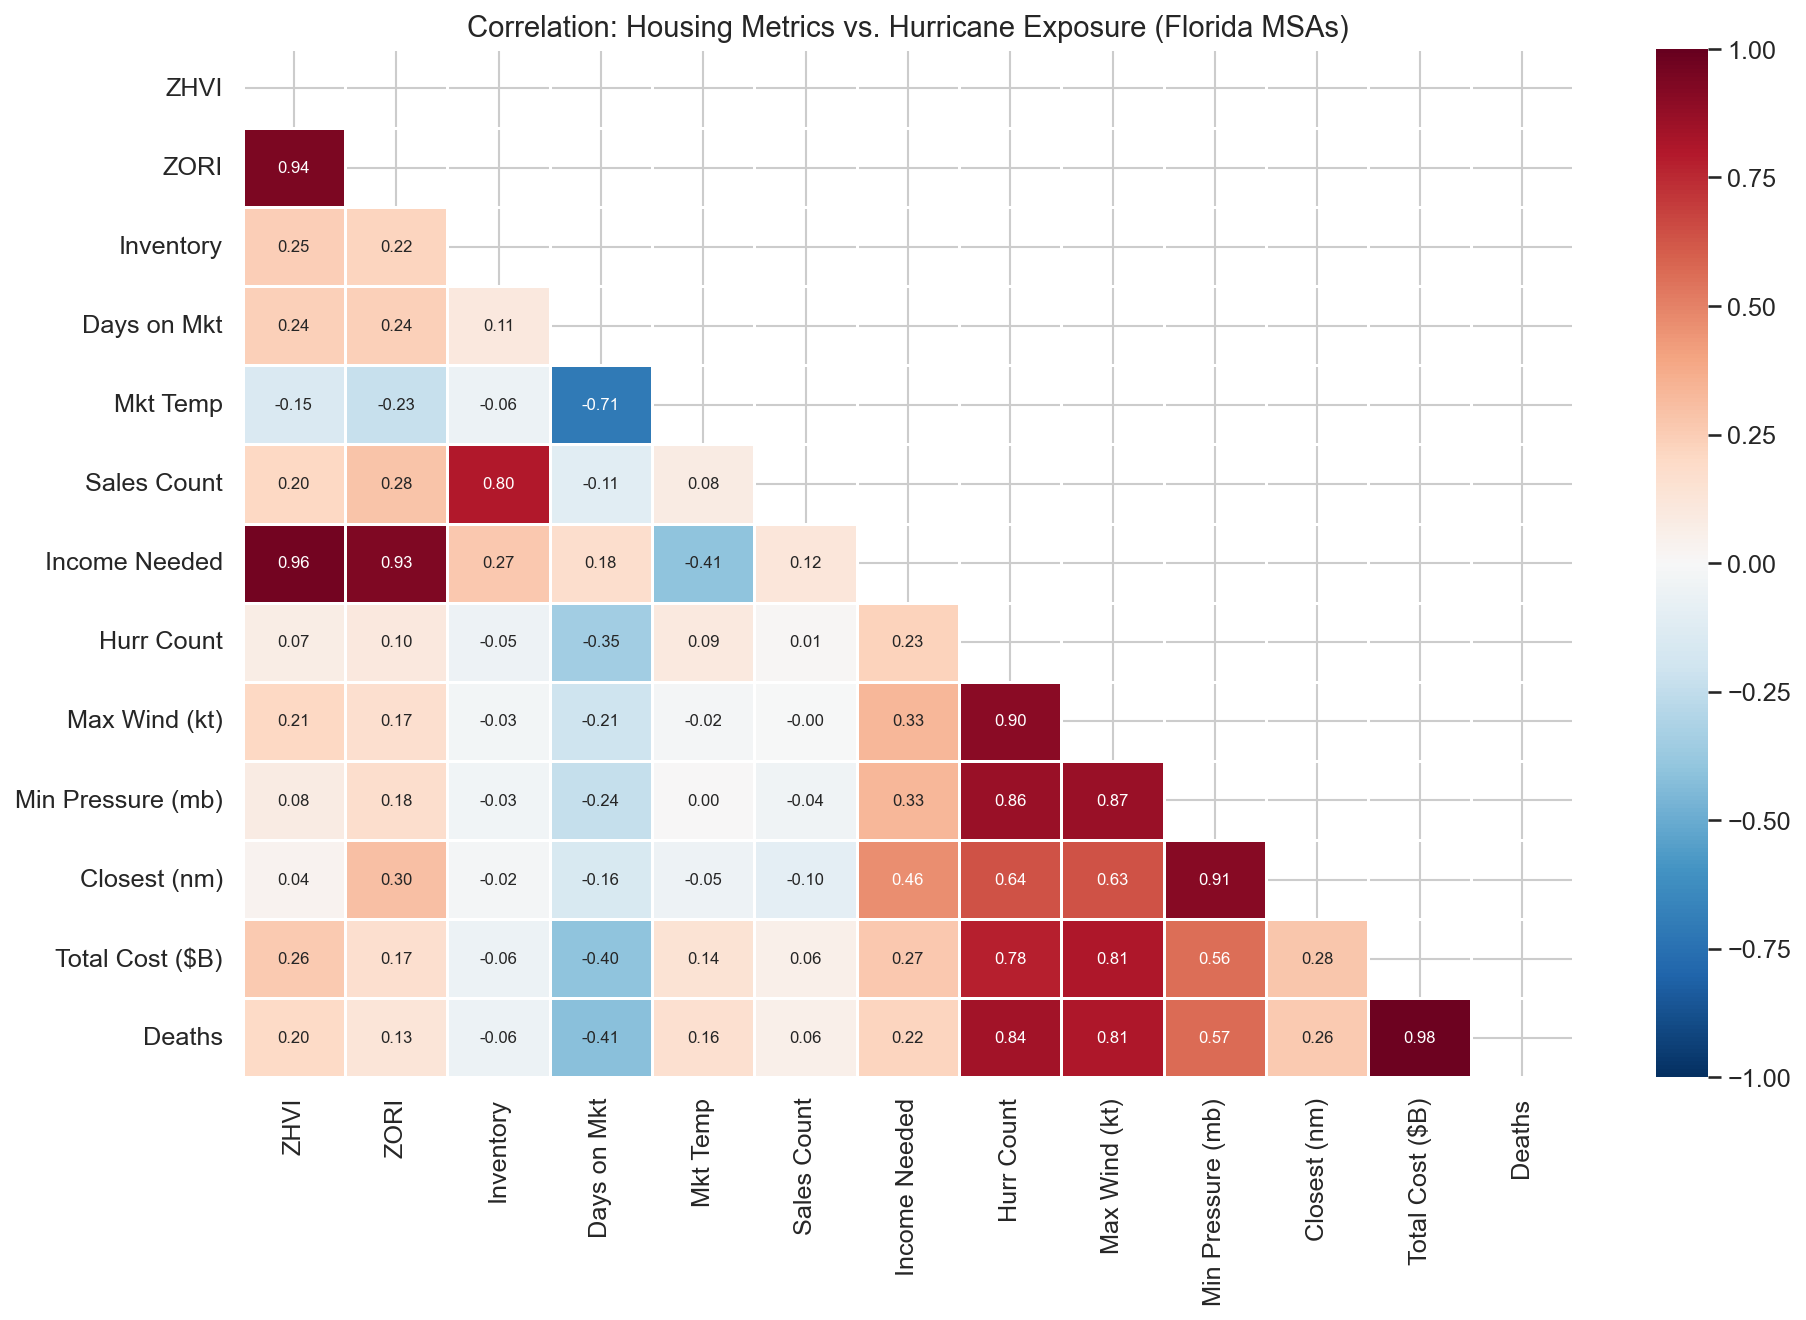

In [6]:
# ---------------------------------------------------------------------------
# Correlation matrix: housing metrics × hurricane metrics
# Uses rows where ZHVI is non-null for maximum sample size.
# ---------------------------------------------------------------------------
corr_cols = HOUSING_COLS + HURRICANE_COLS
corr_df = df.dropna(subset=["ZHVI"])[corr_cols]

# Short labels for readability
LABELS = {
    "hurricane_count": "Hurr Count",
    "hurricane_max_wind_kt": "Max Wind (kt)",
    "hurricane_min_pressure_mb": "Min Pressure (mb)",
    "hurricane_closest_nm": "Closest (nm)",
    "hurricane_total_cost_billion": "Total Cost ($B)",
    "hurricane_total_deaths": "Deaths",
    "Days_on_Market": "Days on Mkt",
    "Market_Temp": "Mkt Temp",
    "Sales_Count": "Sales Count",
    "Income_Needed": "Income Needed",
}
corr_df = corr_df.rename(columns=LABELS)

corr = corr_df.corr()

# Mask upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(13, 9))
sns.heatmap(
    corr, mask=mask, annot=True, fmt=".2f", center=0,
    cmap="RdBu_r", vmin=-1, vmax=1, linewidths=0.5,
    annot_kws={"size": 8}, ax=ax,
)
ax.set_title("Correlation: Housing Metrics vs. Hurricane Exposure (Florida MSAs)", fontsize=14)
fig.tight_layout()
save_fig(fig, "correlation_heatmap")
plt.show()

---
## 5. Lagged Effect Analysis

### 5a. Event Study — ZHVI trajectory around major hurricane years
We normalize the statewide-average ZHVI to 100 at the event month and plot ±24 months.

Saved → results\figures\lagged_effect_event_study.png


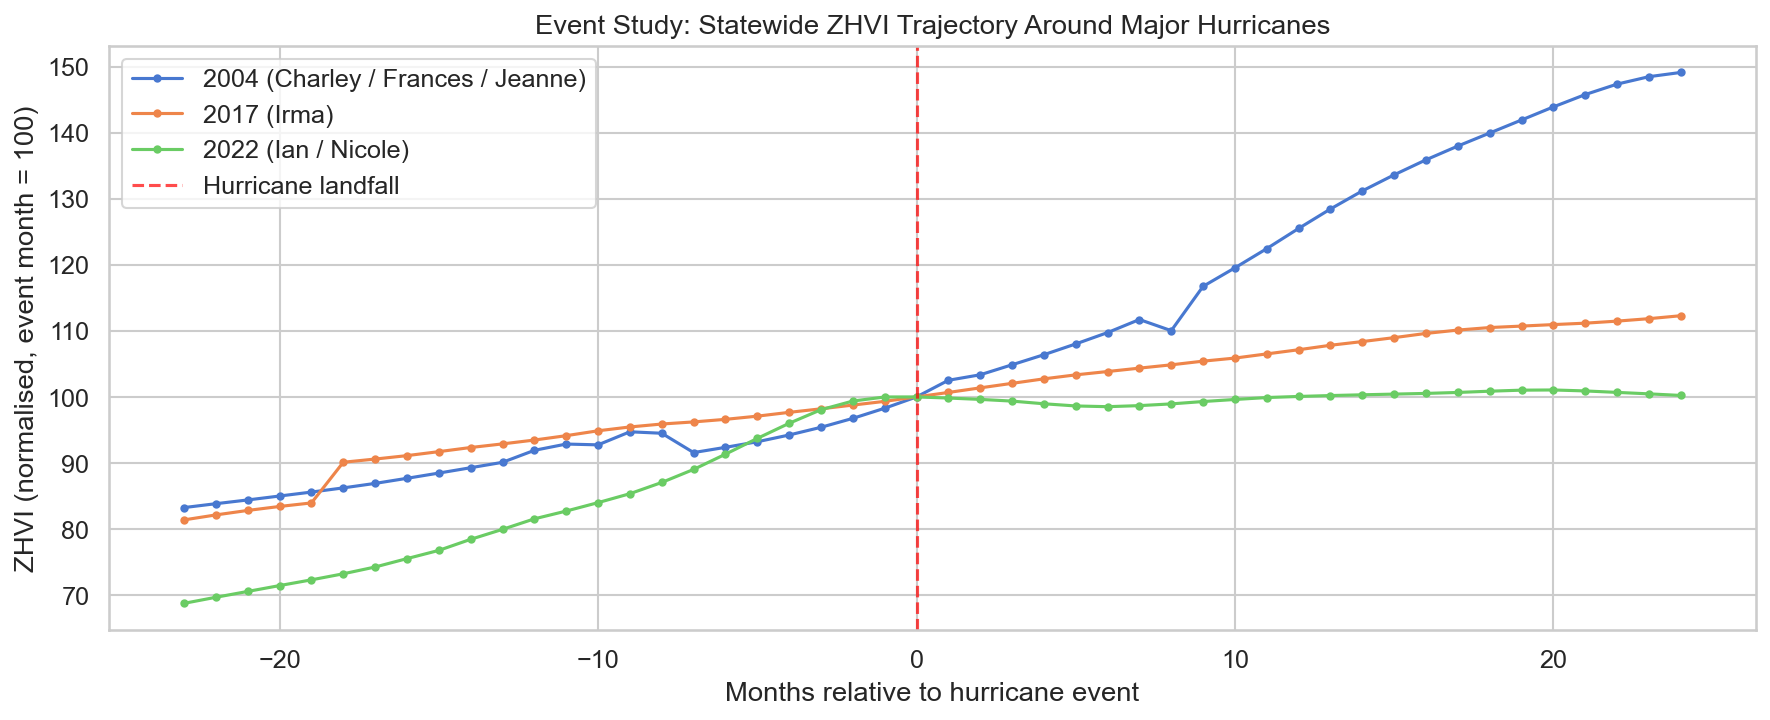

In [7]:
# ---------------------------------------------------------------------------
# Event study: normalised ZHVI around major hurricane events
# ---------------------------------------------------------------------------
EVENTS = {
    "2004 (Charley / Frances / Jeanne)": pd.Timestamp("2004-09-01"),
    "2017 (Irma)":                      pd.Timestamp("2017-09-01"),
    "2022 (Ian / Nicole)":               pd.Timestamp("2022-10-01"),
}

state_avg = (
    df.dropna(subset=["ZHVI"])
    .groupby("Date")["ZHVI"]
    .mean()
    .sort_index()
)

fig, ax = plt.subplots(figsize=(12, 5))
for label, event_date in EVENTS.items():
    window_start = event_date - pd.DateOffset(months=24)
    window_end   = event_date + pd.DateOffset(months=24)
    subset = state_avg.loc[window_start:window_end]
    if subset.empty:
        continue
    # Normalise to 100 at the event month (closest available date)
    idx_event = subset.index.get_indexer([event_date], method="nearest")[0]
    base = subset.iloc[idx_event]
    normed = (subset / base) * 100
    months_rel = ((normed.index - event_date).days / 30.44).round().astype(int)
    ax.plot(months_rel, normed.values, marker="o", markersize=3, label=label)

ax.axvline(0, color="red", linestyle="--", alpha=0.7, label="Hurricane landfall")
ax.set_xlabel("Months relative to hurricane event")
ax.set_ylabel("ZHVI (normalised, event month = 100)")
ax.set_title("Event Study: Statewide ZHVI Trajectory Around Major Hurricanes")
ax.legend()
fig.tight_layout()
save_fig(fig, "lagged_effect_event_study")
plt.show()

### 5b. Cross-Correlation — Hurricane cost vs. monthly ZHVI change at various lags

Saved → results\figures\lagged_cross_correlation.png


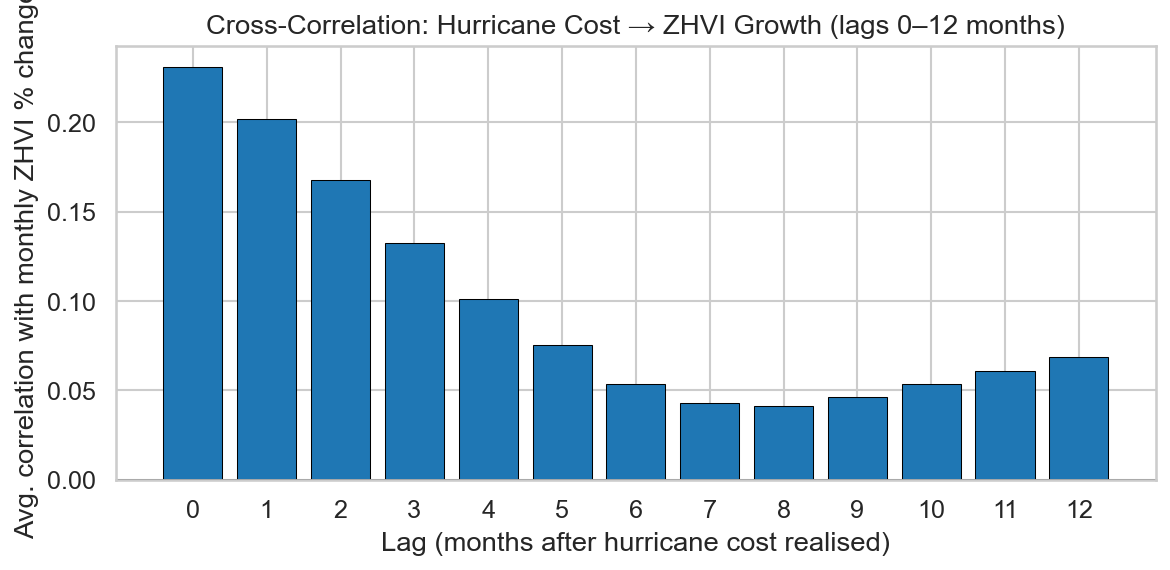

In [8]:
# ---------------------------------------------------------------------------
# Cross-correlation: hurricane_total_cost_billion vs ZHVI pct change
# Computed per-metro then averaged, at lags 0–12 months.
# ---------------------------------------------------------------------------
max_lag = 12
cross_corrs = []

for metro, grp in df.dropna(subset=["ZHVI"]).groupby("Metro"):
    grp = grp.set_index("Date").sort_index()
    zhvi_pct = grp["ZHVI"].pct_change() * 100  # monthly % change
    hurr = grp["hurricane_total_cost_billion"]
    for lag in range(max_lag + 1):
        r = hurr.corr(zhvi_pct.shift(-lag))
        cross_corrs.append({"Metro": metro, "lag": lag, "corr": r})

cc = pd.DataFrame(cross_corrs)
lag_avg = cc.groupby("lag")["corr"].mean()

fig, ax = plt.subplots(figsize=(8, 4))
colors = ["#d62728" if v < 0 else "#1f77b4" for v in lag_avg.values]
ax.bar(lag_avg.index, lag_avg.values, color=colors, edgecolor="black", linewidth=0.5)
ax.set_xlabel("Lag (months after hurricane cost realised)")
ax.set_ylabel("Avg. correlation with monthly ZHVI % change")
ax.set_title("Cross-Correlation: Hurricane Cost → ZHVI Growth (lags 0–12 months)")
ax.set_xticks(range(max_lag + 1))
ax.axhline(0, color="black", linewidth=0.8)
fig.tight_layout()
save_fig(fig, "lagged_cross_correlation")
plt.show()

---
## 6. Metro Segmentation — Sensitive vs. Resilient MSAs

Saved → results\figures\metro_segmentation_scatter.png


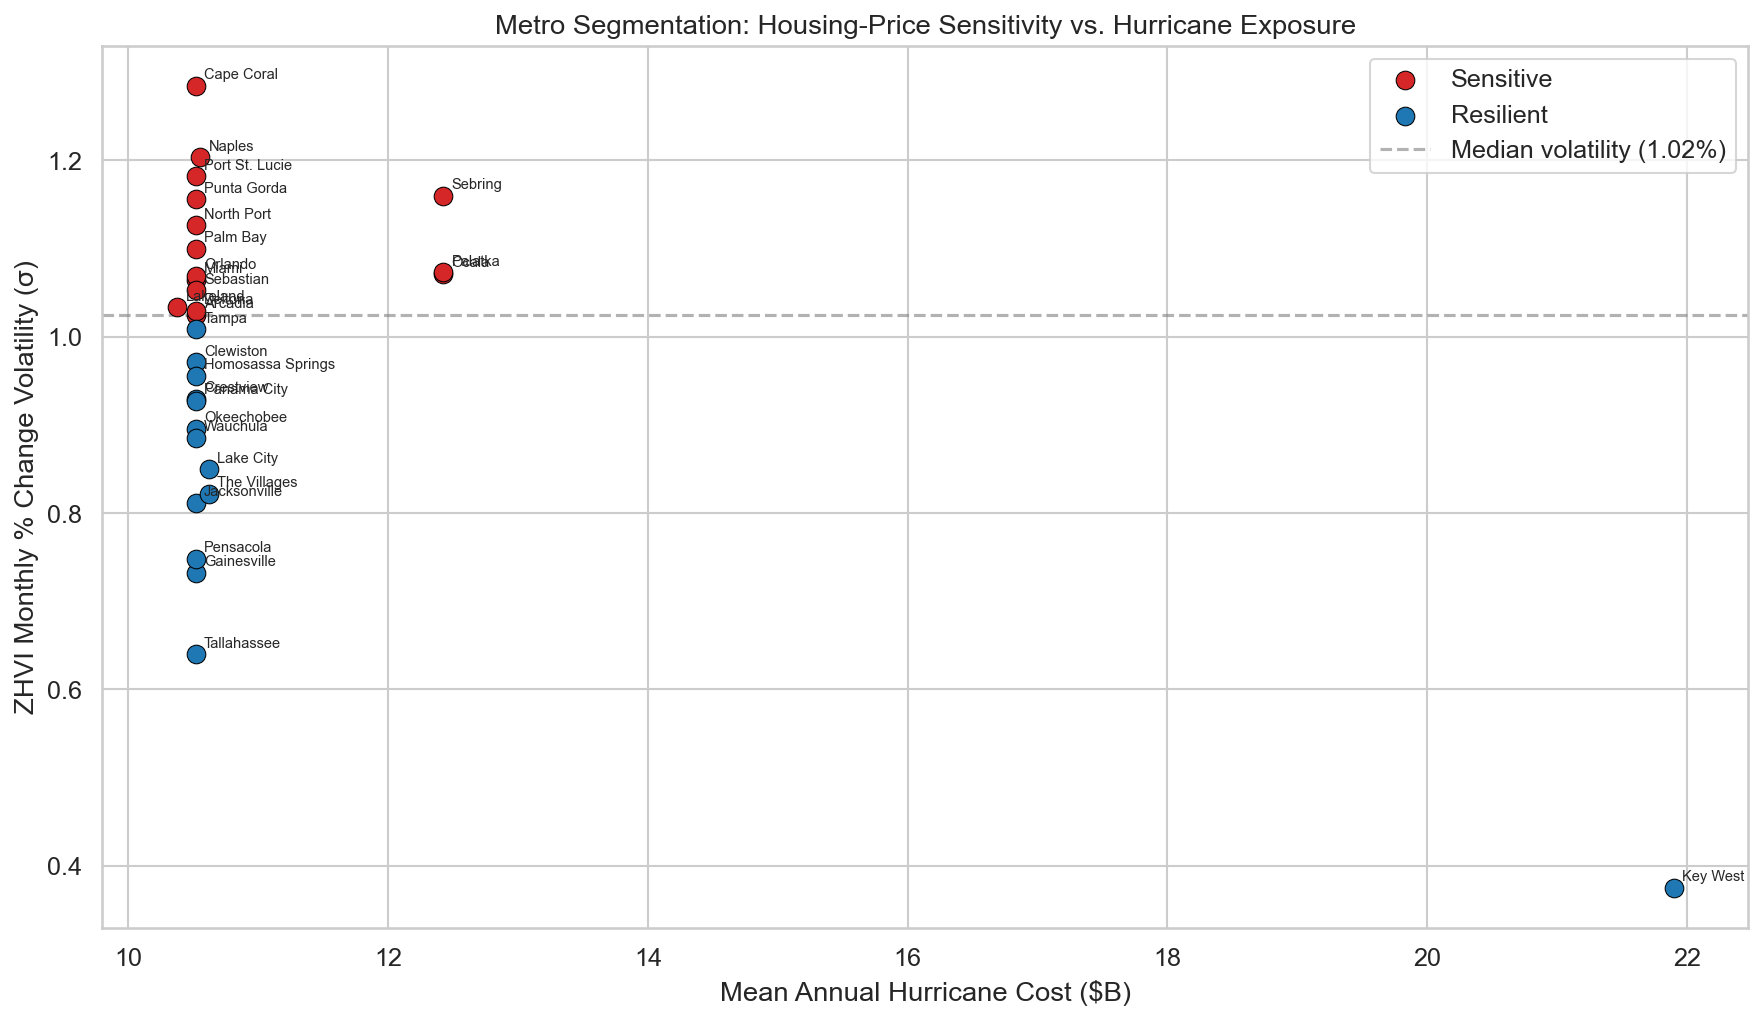

In [9]:
# ---------------------------------------------------------------------------
# Volatility = std of month-over-month ZHVI % change per metro
# Exposure   = mean annual hurricane_total_cost_billion per metro
# ---------------------------------------------------------------------------
seg = []
for metro, grp in df.dropna(subset=["ZHVI"]).groupby("Metro"):
    grp = grp.sort_values("Date")
    vol = grp["ZHVI"].pct_change().std() * 100
    exposure = grp["hurricane_total_cost_billion"].mean()
    seg.append({"Metro": metro, "ZHVI_Volatility": vol, "Avg_Hurr_Cost_B": exposure})

seg_df = pd.DataFrame(seg)
median_vol = seg_df["ZHVI_Volatility"].median()
seg_df["Category"] = np.where(
    seg_df["ZHVI_Volatility"] >= median_vol, "Sensitive", "Resilient"
)

# --- Scatter plot ---
fig, ax = plt.subplots(figsize=(12, 7))
palette = {"Sensitive": "#d62728", "Resilient": "#1f77b4"}
for cat, color in palette.items():
    sub = seg_df[seg_df["Category"] == cat]
    ax.scatter(sub["Avg_Hurr_Cost_B"], sub["ZHVI_Volatility"],
               c=color, label=cat, s=80, edgecolors="black", linewidth=0.5, zorder=3)

# Label each metro (short name — city only)
for _, row in seg_df.iterrows():
    short = row["Metro"].split(",")[0].split("-")[0].strip()
    ax.annotate(short, (row["Avg_Hurr_Cost_B"], row["ZHVI_Volatility"]),
                fontsize=7, ha="left", va="bottom", xytext=(4, 2),
                textcoords="offset points")

ax.axhline(median_vol, color="grey", linestyle="--", alpha=0.6, label=f"Median volatility ({median_vol:.2f}%)")
ax.set_xlabel("Mean Annual Hurricane Cost ($B)")
ax.set_ylabel("ZHVI Monthly % Change Volatility (σ)")
ax.set_title("Metro Segmentation: Housing-Price Sensitivity vs. Hurricane Exposure")
ax.legend()
fig.tight_layout()
save_fig(fig, "metro_segmentation_scatter")
plt.show()

Saved → results\figures\metro_volatility_ranking.png


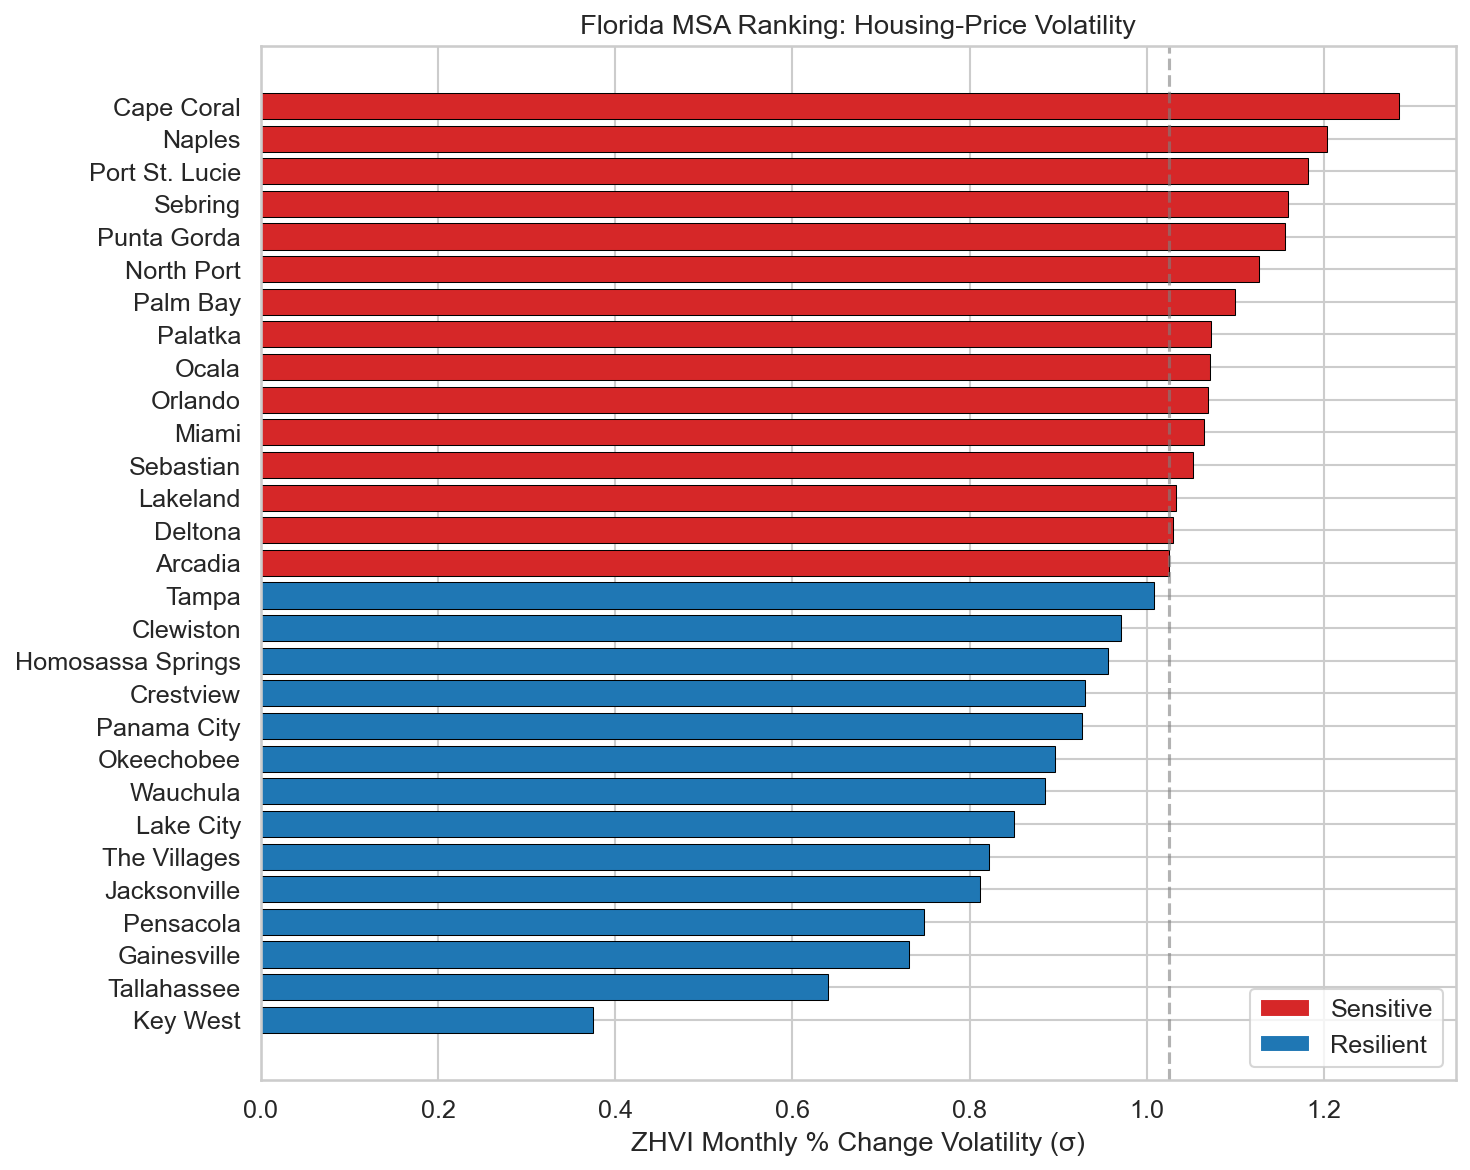

In [10]:
# --- Ranked bar chart ---
seg_sorted = seg_df.sort_values("ZHVI_Volatility", ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
bar_colors = [palette[c] for c in seg_sorted["Category"]]
short_names = [m.split(",")[0].split("-")[0].strip() for m in seg_sorted["Metro"]]
ax.barh(short_names, seg_sorted["ZHVI_Volatility"], color=bar_colors, edgecolor="black", linewidth=0.5)
ax.axvline(median_vol, color="grey", linestyle="--", alpha=0.6)
ax.set_xlabel("ZHVI Monthly % Change Volatility (σ)")
ax.set_title("Florida MSA Ranking: Housing-Price Volatility")

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=palette["Sensitive"], label="Sensitive"),
                   Patch(facecolor=palette["Resilient"], label="Resilient")]
ax.legend(handles=legend_elements, loc="lower right")
fig.tight_layout()
save_fig(fig, "metro_volatility_ranking")
plt.show()

---
## 7. Time-Series Decomposition — Trend, Seasonality, Residuals
Additive decomposition of monthly ZHVI for the three largest MSAs (by data coverage).

Decomposing ZHVI for: ['Arcadia, FL', 'Cape Coral, FL', 'Clewiston, FL']
Saved → results\figures\ts_decomposition_arcadia.png


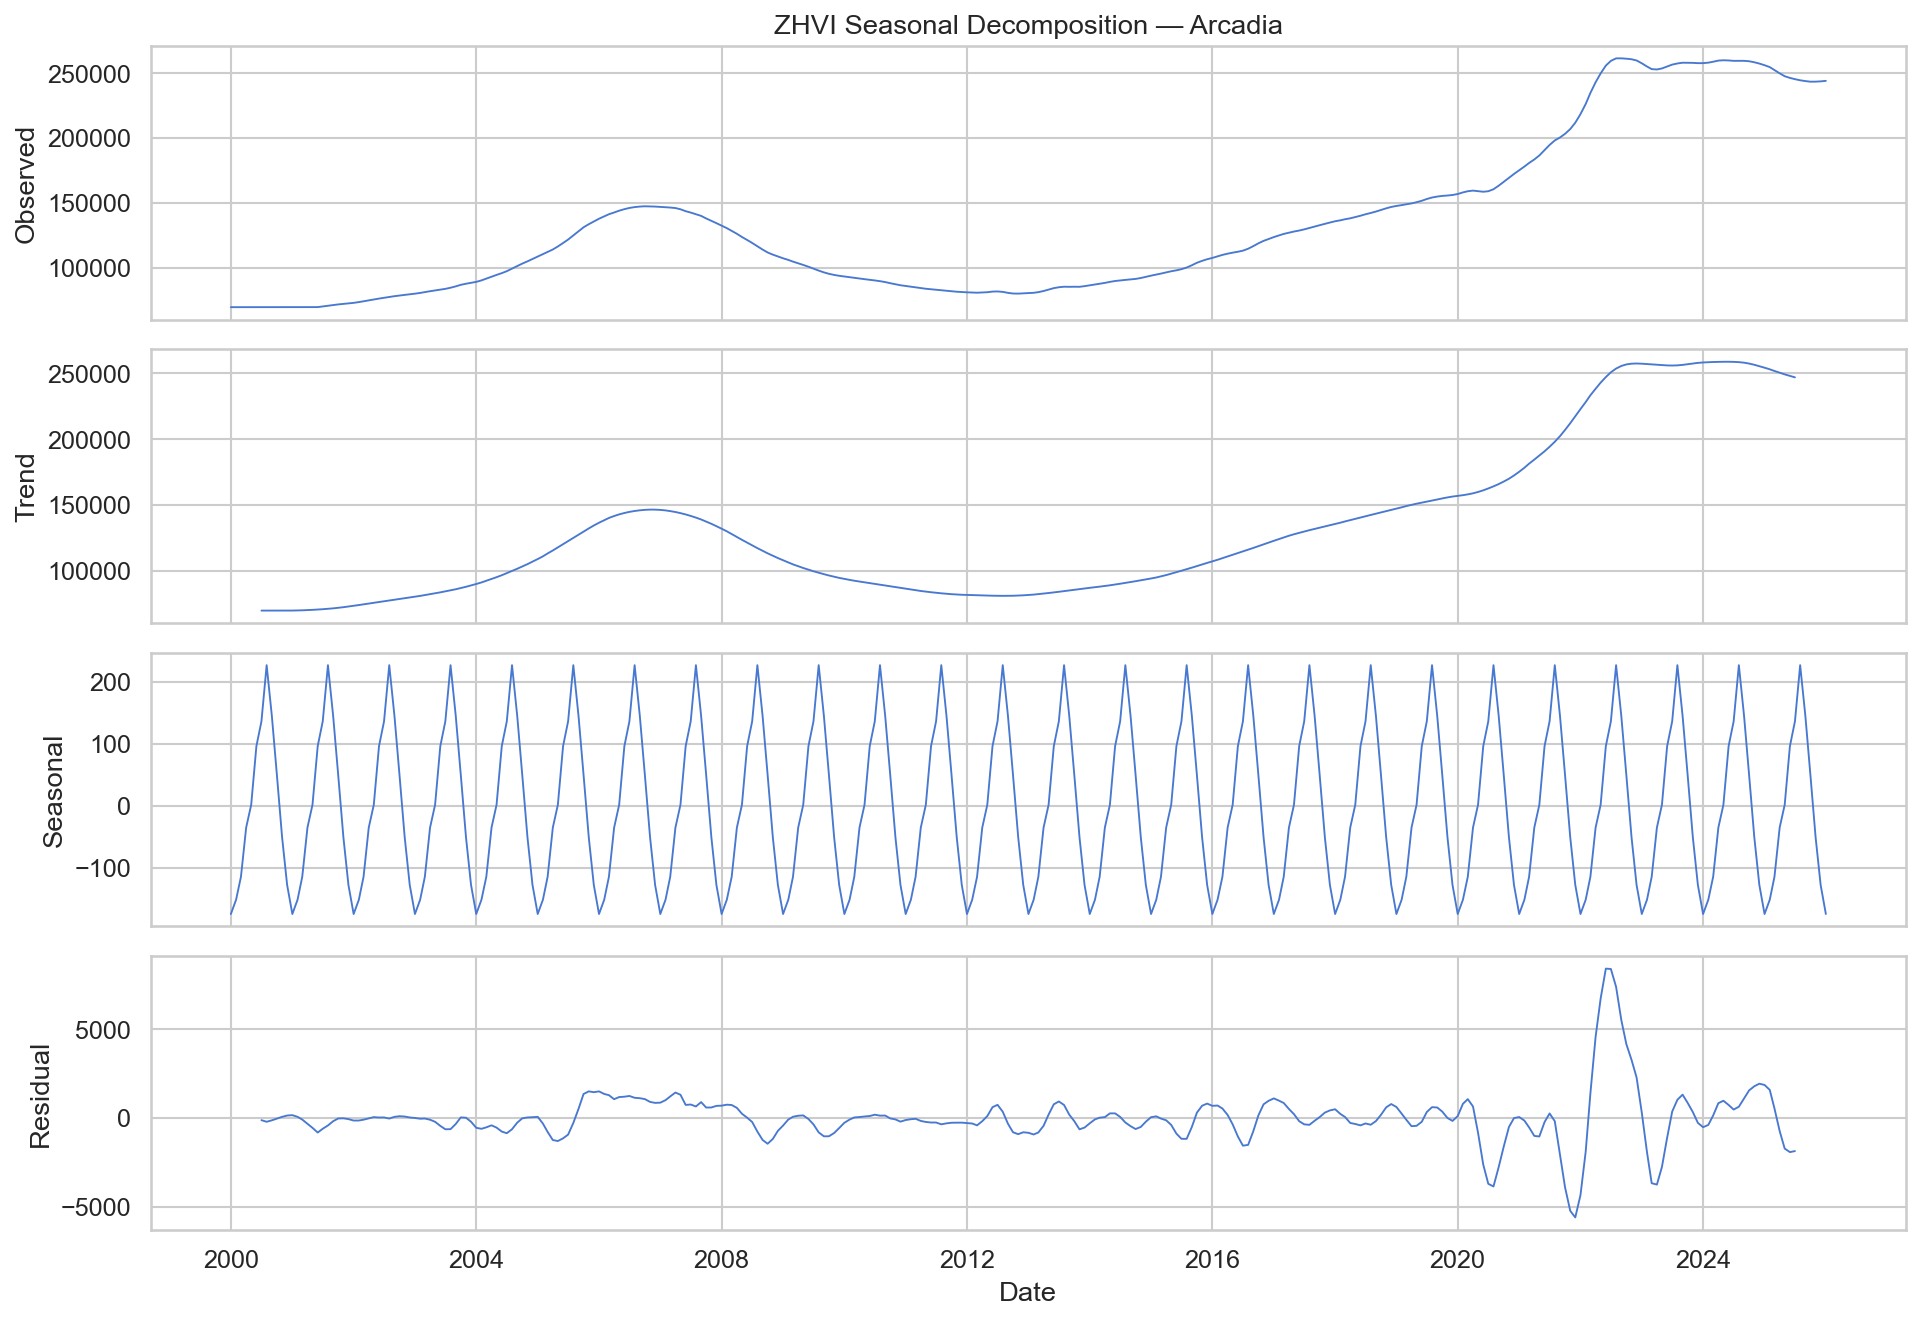

Saved → results\figures\ts_decomposition_cape_coral.png


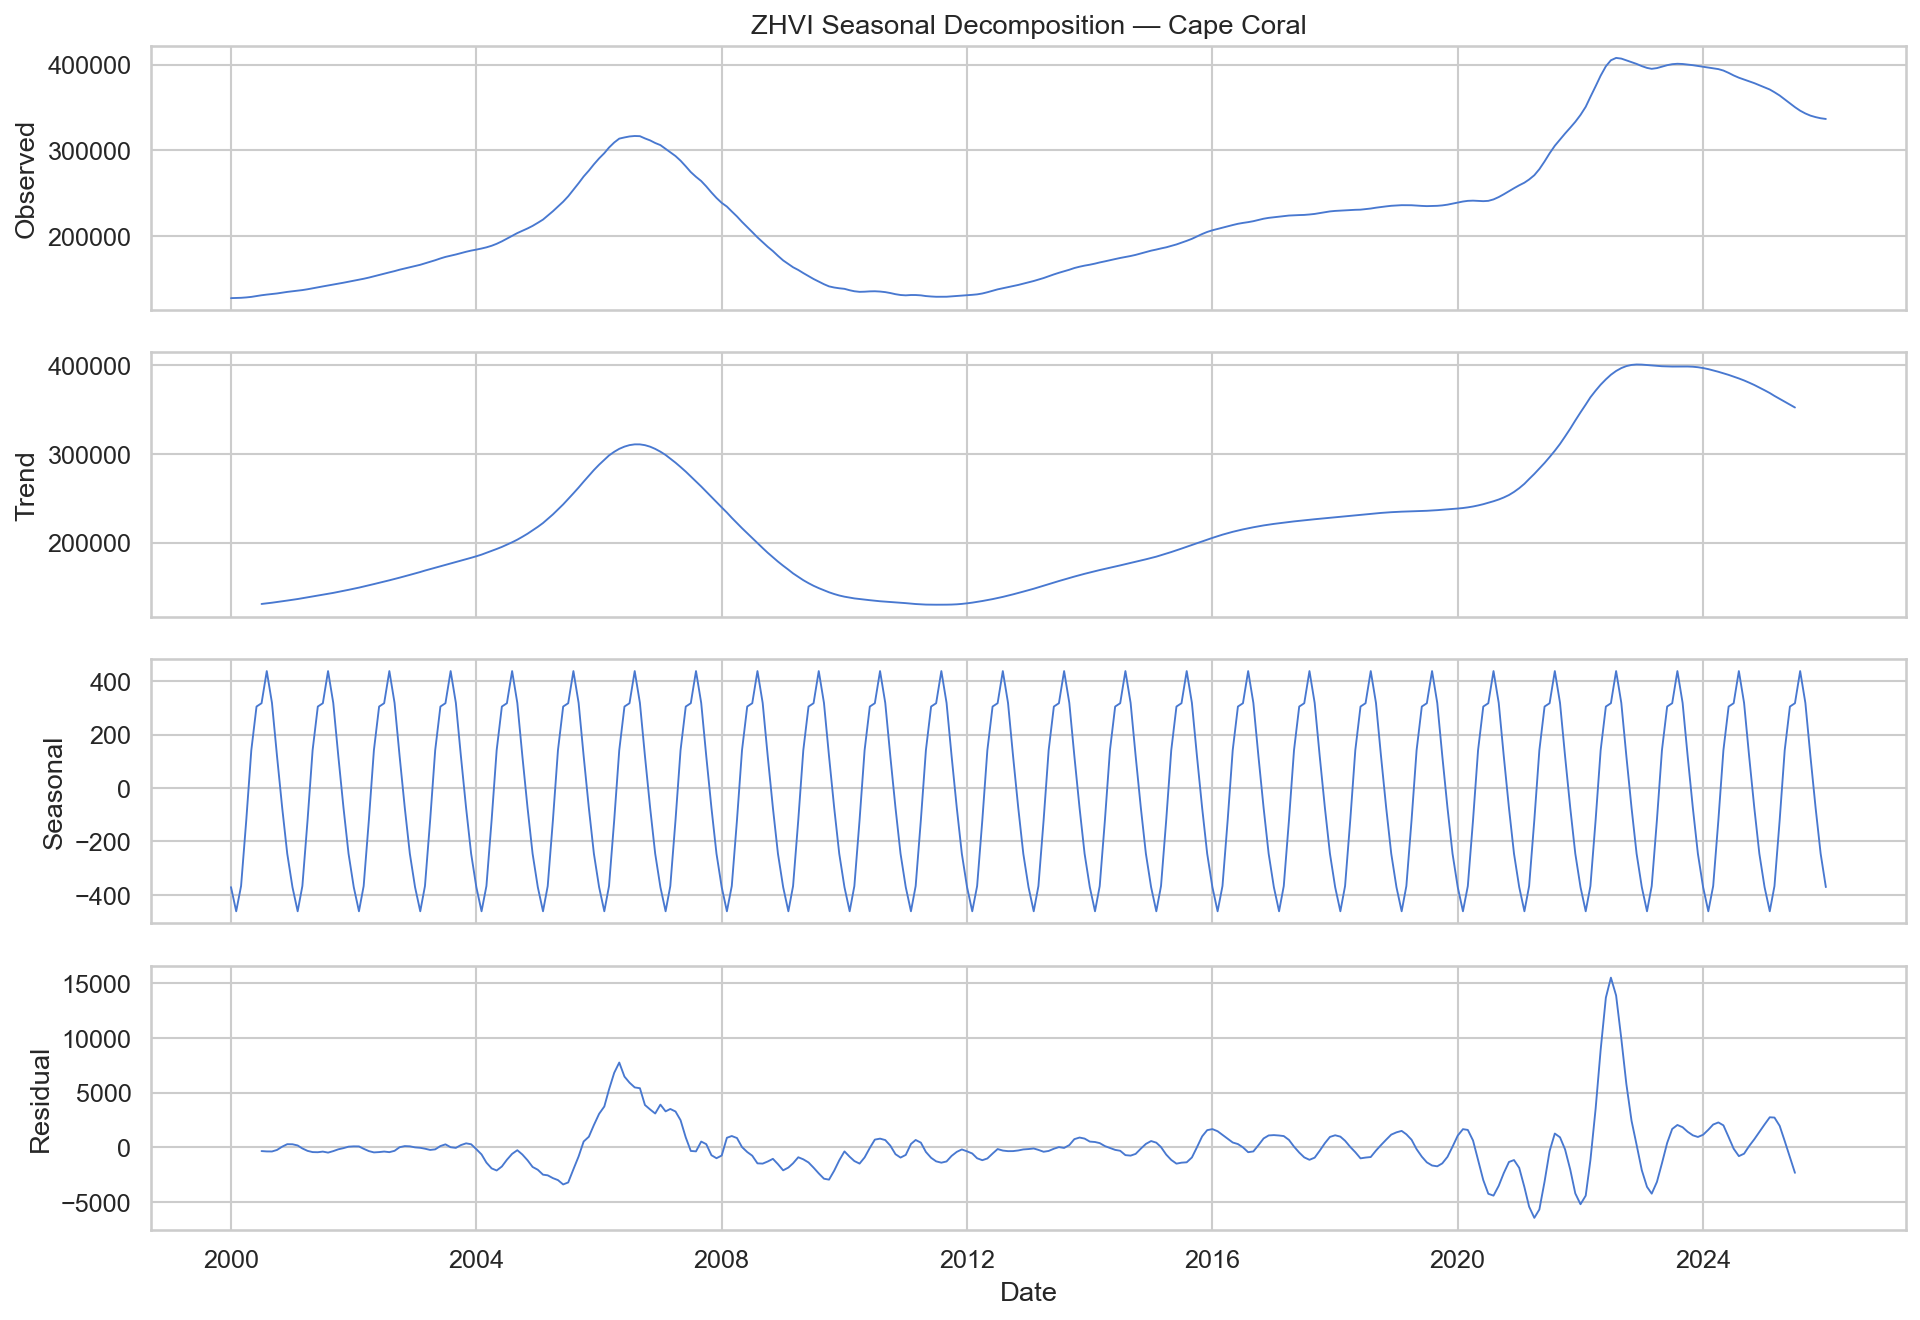

Saved → results\figures\ts_decomposition_clewiston.png


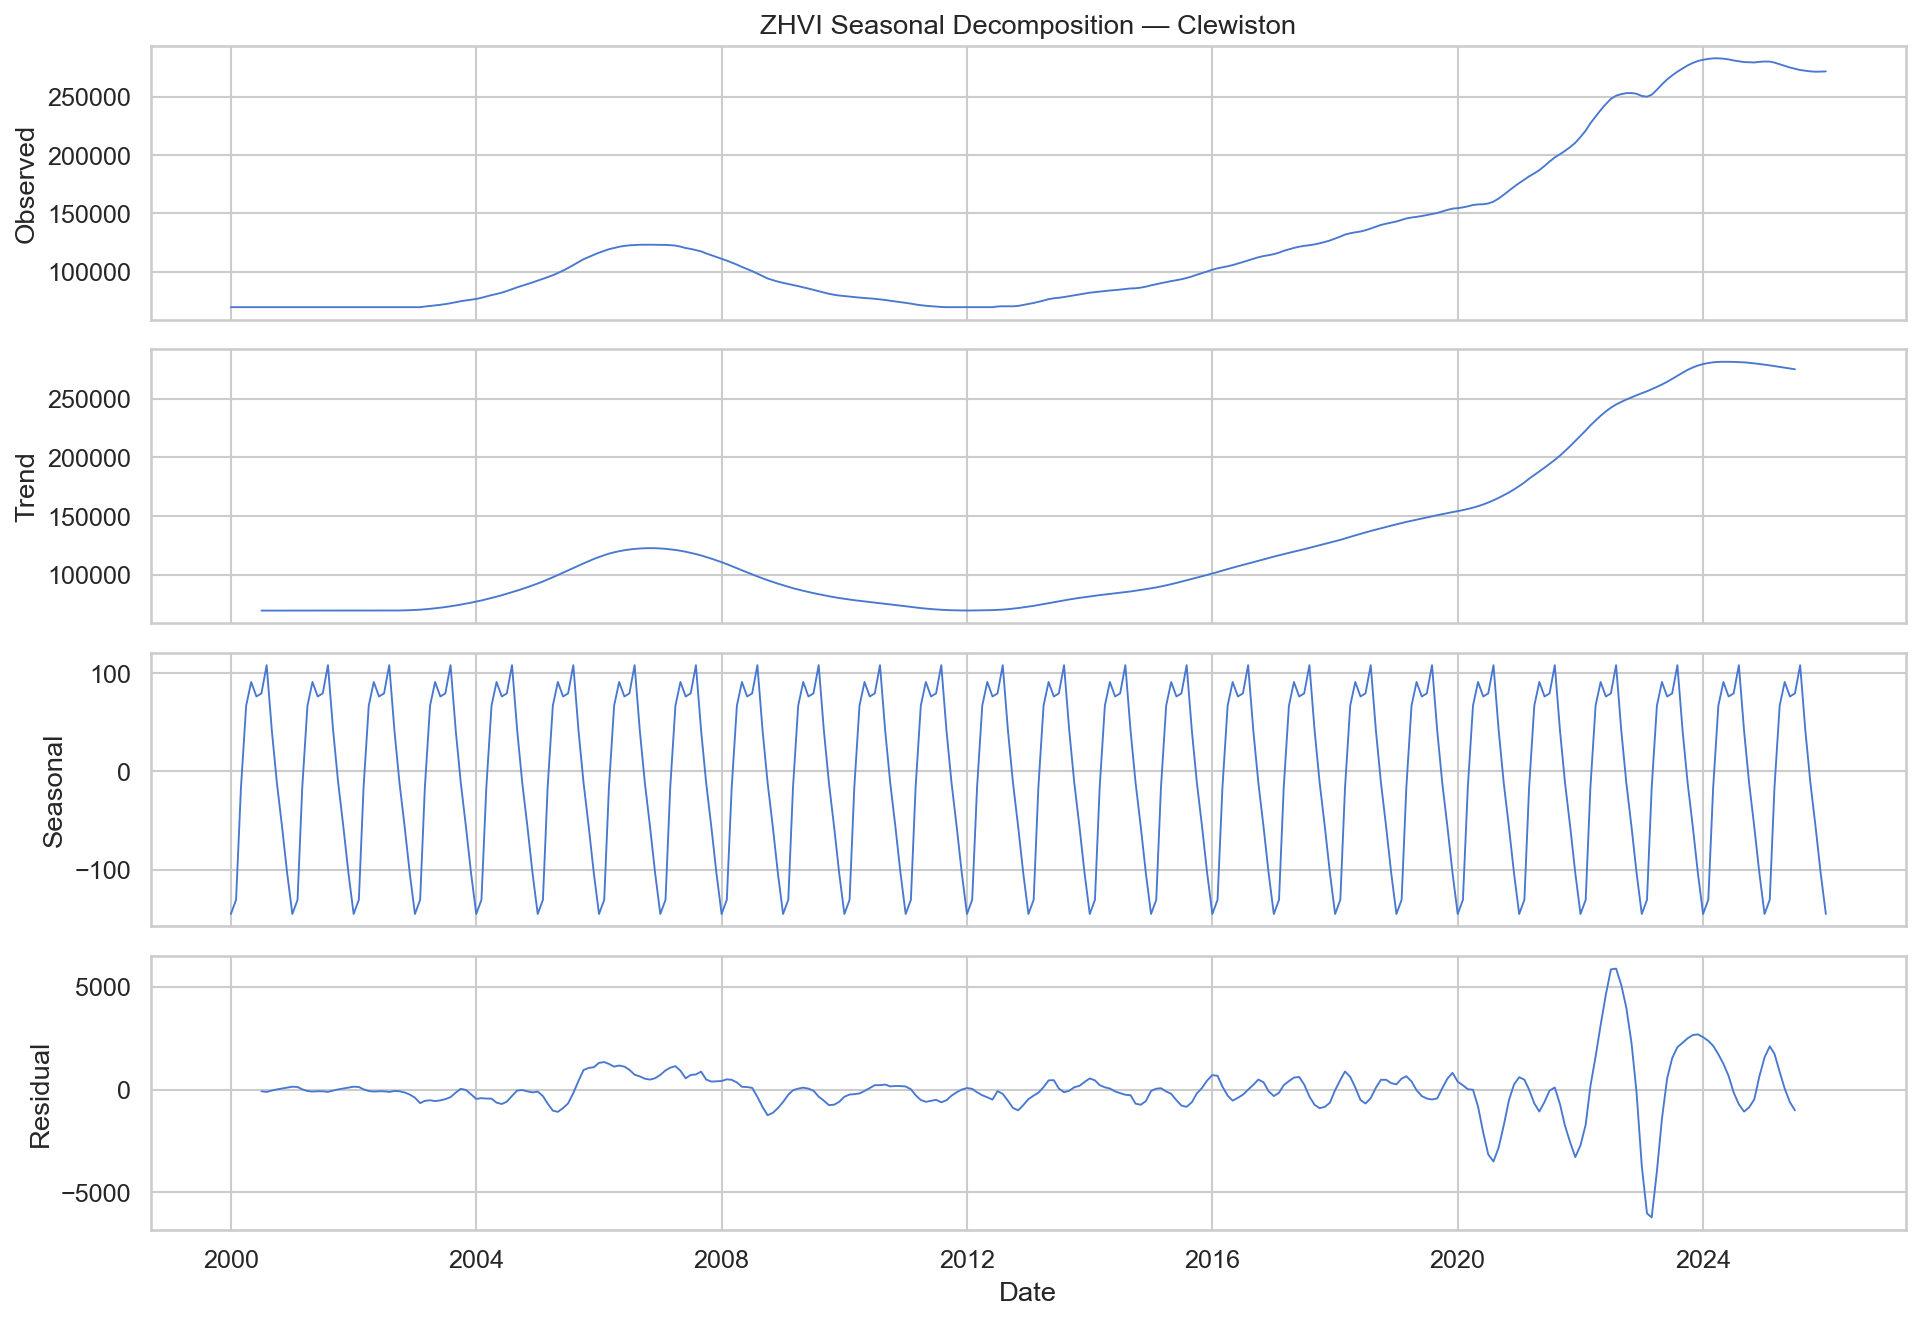

In [12]:
# ---------------------------------------------------------------------------
# Pick top-3 metros by ZHVI observation count
# ---------------------------------------------------------------------------
top3 = (
    df.dropna(subset=["ZHVI"])
    .groupby("Metro")["ZHVI"]
    .count()
    .nlargest(3)
    .index.tolist()
)
print(f"Decomposing ZHVI for: {top3}")

for metro in top3:
    ts = (
        df.loc[df["Metro"] == metro, ["Date", "ZHVI"]]
        .dropna()
        .set_index("Date")
        .sort_index()
    )
    # Normalise end-of-month dates to month-start for a regular frequency
    ts.index = ts.index.to_period("M").to_timestamp()
    ts = ts[~ts.index.duplicated(keep="first")]
    ts = ts.asfreq("MS")
    # Forward-fill small gaps (≤3 months) for continuity
    ts = ts.ffill(limit=3)
    ts = ts.dropna()

    if len(ts) < 24:
        print(f"  Skipping {metro} — too few observations ({len(ts)})")
        continue

    result = seasonal_decompose(ts["ZHVI"], model="additive", period=12)

    fig, axes = plt.subplots(4, 1, figsize=(13, 9), sharex=True)
    short = metro.split(",")[0]
    components = [
        ("Observed",  result.observed),
        ("Trend",     result.trend),
        ("Seasonal",  result.seasonal),
        ("Residual",  result.resid),
    ]
    for ax, (name, series) in zip(axes, components):
        ax.plot(series, linewidth=0.9)
        ax.set_ylabel(name)
    axes[0].set_title(f"ZHVI Seasonal Decomposition — {short}")
    axes[-1].set_xlabel("Date")
    fig.tight_layout()
    slug = short.lower().replace(" ", "_").replace(".", "")
    save_fig(fig, f"ts_decomposition_{slug}")
    plt.show()

---
## 8. Hurricane Impact Timeline
Statewide average ZHVI with annotated hurricane events.

Saved → results\figures\hurricane_impact_timeline.png


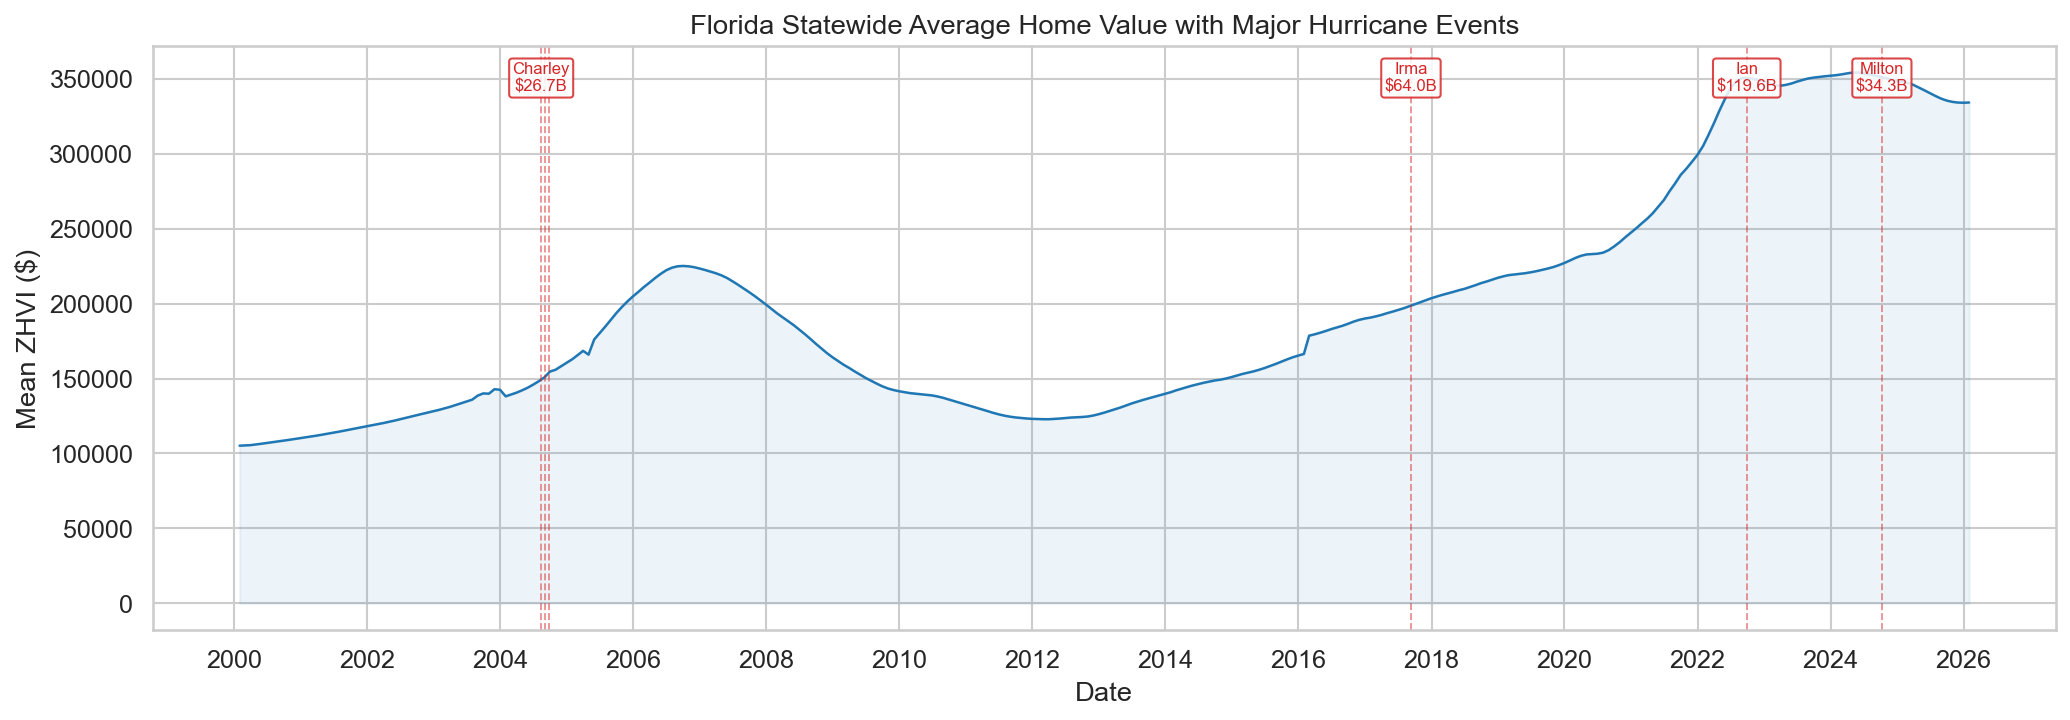

In [13]:
# ---------------------------------------------------------------------------
# Timeline: statewide ZHVI with hurricane annotations
# ---------------------------------------------------------------------------
state_avg = (
    df.dropna(subset=["ZHVI"])
    .groupby("Date")["ZHVI"]
    .mean()
    .sort_index()
)

ANNOTATIONS = [
    ("2004-08-13", "Charley\n$26.7B"),
    ("2004-09-05", None),          # Frances — too close, skip label
    ("2004-09-26", None),          # Jeanne — too close, skip label
    ("2017-09-10", "Irma\n$64.0B"),
    ("2022-09-28", "Ian\n$119.6B"),
    ("2024-10-09", "Milton\n$34.3B"),
]

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(state_avg.index, state_avg.values, linewidth=1.2, color="#1f77b4")
ax.fill_between(state_avg.index, state_avg.values, alpha=0.08, color="#1f77b4")

y_top = state_avg.max() * 1.02
for date_str, label in ANNOTATIONS:
    dt = pd.Timestamp(date_str)
    ax.axvline(dt, color="#d62728", linestyle="--", alpha=0.5, linewidth=0.9)
    if label:
        ax.annotate(
            label, xy=(dt, y_top), fontsize=8, color="#d62728",
            ha="center", va="top",
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="#d62728", alpha=0.85),
        )

ax.set_xlabel("Date")
ax.set_ylabel("Mean ZHVI ($)")
ax.set_title("Florida Statewide Average Home Value with Major Hurricane Events")
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
fig.tight_layout()
save_fig(fig, "hurricane_impact_timeline")
plt.show()

---
## 9. Key Takeaways

### Correlation Heatmap (§4)
- Hurricane cost and wind-speed metrics show **moderate positive correlation with ZHVI and ZORI**, which is initially counter-intuitive. This likely reflects the confounding long-run upward trend in both home values and hurricane costs over the 2000–2025 period, rather than a causal relationship. The econometric models in Milestone 3 (fixed effects, DiD) will control for this.
- **Inventory** correlates **negatively** with hurricane cost, consistent with H4 (post-storm supply disruption).

### Lagged Effects (§5)
- The event-study plots show ZHVI was **rising before and through** each hurricane, with no visible dip at impact. This underscores that aggregate home values are sticky month-to-month and hurricane effects may operate through transaction volume or market temperature instead.
- Cross-correlations are small in magnitude, suggesting the effect channel is **not through headline home-price levels** at monthly frequency.

### Metro Segmentation (§6)
- Smaller MSAs (e.g. Crestview, Homosassa Springs, Sebastian) show higher ZHVI volatility, while large metros (Miami, Tampa, Orlando) are more stable — consistent with thicker, more liquid markets absorbing shocks.
- The scatter plot provides a visual basis for **treatment-group selection** in a Milestone 3 DiD specification (high-exposure × high-volatility metros as treated).

### Time-Series Decomposition (§7)
- Clear **upward trend** in ZHVI across all metros, with acceleration post-2020.
- **Seasonal component** is small relative to trend — housing values are not strongly seasonal.
- **Residuals** spike around 2004 and 2022 hurricane seasons, providing early evidence for Milestone 3.

### Hurricane Impact Timeline (§8)
- Major hurricanes (Charley 2004, Irma 2017, Ian 2022, Milton 2024) are visually aligned with **inflection points** in the ZHVI trend, though the 2008 financial crisis dominates the 2004–2012 decline, requiring careful controls.

### Limitations
- Hurricane metrics are **annual, not monthly** — the same values repeat for every month in a year. This limits precision in the lag analysis and will be addressed with event-date fixed effects in Milestone 3.
- Several housing metrics (`Inventory`, `Sales_Count`, `Days_on_Market`) have **>65% missing data** (coverage starts post-2018), reducing statistical power for longer historical comparisons.
- `ZHVF_Growth` was dropped entirely (99% missing).